## Estimating Homography matrix

In [49]:
import geopandas as gpd
import pandas as pd
import fiona

print(f"Fiona supported drivers {fiona.supported_drivers}\n")

print(f"Add KML to Fiona supported drivers...\n")
fiona.drvsupport.supported_drivers['KML'] = 'rw'

print(f"Fiona supported drivers {fiona.supported_drivers}")

Fiona supported drivers {'DXF': 'rw', 'CSV': 'raw', 'OpenFileGDB': 'raw', 'ESRIJSON': 'r', 'ESRI Shapefile': 'raw', 'FlatGeobuf': 'raw', 'GeoJSON': 'raw', 'GeoJSONSeq': 'raw', 'GPKG': 'raw', 'GML': 'rw', 'OGR_GMT': 'rw', 'GPX': 'rw', 'MapInfo File': 'raw', 'DGN': 'raw', 'S57': 'r', 'SQLite': 'raw', 'TopoJSON': 'r', 'KML': 'rw'}

Add KML to Fiona supported drivers...

Fiona supported drivers {'DXF': 'rw', 'CSV': 'raw', 'OpenFileGDB': 'raw', 'ESRIJSON': 'r', 'ESRI Shapefile': 'raw', 'FlatGeobuf': 'raw', 'GeoJSON': 'raw', 'GeoJSONSeq': 'raw', 'GPKG': 'raw', 'GML': 'rw', 'OGR_GMT': 'rw', 'GPX': 'rw', 'MapInfo File': 'raw', 'DGN': 'raw', 'S57': 'r', 'SQLite': 'raw', 'TopoJSON': 'r', 'KML': 'rw'}


In [50]:
files = [
    'street_rectangle.kml',
    'parche.kml',
    'tree.kml'
]
target_points = {}
for f in files:
    kpoints = gpd.read_file(f)
    coords = list(kpoints["geometry"][0].exterior.coords)
    coords = [c[:2] for c in coords]
    target_points [f.split('.')[0]] = coords

tree = target_points ['tree'][2:4]
target_points.popitem()
target = [target_points[k][i] for i in range(4) for k in target_points.keys()] + tree
#target =  target_points['tree'][2:4] + target_points['parche'] + target_points['street_rectangle']
target
#target_points

[(-103.4277579789723, 20.63654557516515),
 (-103.4277575318885, 20.63653234065061),
 (-103.4277495976675, 20.6365508448116),
 (-103.4277505019519, 20.63653650674235),
 (-103.4277645711312, 20.63657410193639),
 (-103.4277554179388, 20.63654389661254),
 (-103.4277727565876, 20.6365701138996),
 (-103.427762158771, 20.63653953561339),
 (-103.4278021213562, 20.63647239625929),
 (-103.4278175876926, 20.63646121024951)]

In [51]:
df = pd.DataFrame({'x': [t[0] for t in target], 'y': [t[1] for t in target]})
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.x, df.y), crs="EPSG:4326")
gdf.explore()

In [52]:
source_points = {
    'street_rectangle':[(746,641), (816,664), (952,566), (896,558)],
    #'tree_square': [(107, 580), (97,602),(161,593),(166,570)],
    'parche': [(605.5, 674.1), (650.3, 696.1), (729.3, 656), (684.3, 637.5)],
    'tree': [(107.5, 580.6), (95.3, 608.6), (279.6, 580.4), (274.1, 558.4)]
}
tree = source_points ['tree'][2:4]
source_points.popitem()
source = [source_points[k][i] for i in range(4) for k in source_points.keys()] + tree
#source =  source_points['tree'][2:4] + source_points['parche'] + source_points['street_rectangle']
source

[(746, 641),
 (605.5, 674.1),
 (816, 664),
 (650.3, 696.1),
 (952, 566),
 (729.3, 656),
 (896, 558),
 (684.3, 637.5),
 (279.6, 580.4),
 (274.1, 558.4)]

In [53]:
import numpy as np
import cv2

"""Calculate the homography from source to target using RANSAC."""
source = np.array(source).astype(np.float32).reshape(-1, 1, 2)
target = np.array(target).astype(np.float32).reshape(-1, 1, 2)
h, status = cv2.findHomography(source, target)
h

array([[     0.0133,     0.28009,     -103.43],
       [ -0.0026539,   -0.055886,      20.637],
       [ -0.0001286,  -0.0027081,           1]])

In [3]:
import numpy as np

h_calculated = np.array([[ 1.33002904e-02,  2.80091231e-01, -1.03427615e+02],
       [-2.65385918e-03, -5.58855697e-02,  2.06366171e+01],
       [-1.28595347e-04, -2.70808743e-03,  1.00000000e+00]])

* Download filevideo to infer

In [6]:
import gdown

id= '12U_pKaXyFKelniIfPGMxoYI0AOwseSEd'
output = "cruce.mp4"
gdown.download(id=id, output=output)

Downloading...
From: https://drive.google.com/uc?id=12U_pKaXyFKelniIfPGMxoYI0AOwseSEd
To: /home/alanromero/Documents/traffic-conflicts-analysis/src/demo-research/cruce.mp4
100%|██████████| 32.2M/32.2M [00:00<00:00, 148MB/s] 


'cruce.mp4'

Measure elapsed time in seconds https://stackoverflow.com/questions/7370801/how-do-i-measure-elapsed-time-in-python


In [4]:
from ultralytics import YOLO, checks, hub
import cv2


model = YOLO('yolov9e.pt')
video = cv2.VideoCapture('cruce.mp4')

frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
entities = {}

video_analysis = {
    'names': [],
    'boxes': [],
    'pos_msec': [], 
    'frames': []
    }

for i_frame in range(int(video.get(cv2.CAP_PROP_FRAME_COUNT))):
    ret, frame = video.read()
    if not ret:
        continue
    # Track all objects in the frame
    results = model.track(source=frame, persist=True, show=False, verbose=False)
    # Capture relevant data
    video_analysis['frames'].append(frame)
    video_analysis['names'].append(results[0].names) # do we really need this?
    video_analysis['boxes'].append(results[0].boxes) 
    video_analysis['pos_msec'].append(video.get(cv2.CAP_PROP_POS_MSEC)) # current position in milliseconds


- https://docs.opencv.org/4.9.0/d4/d15/group__videoio__flags__base.html#gaeb8dd9c89c10a5c63c139bf7c4f5704d

- https://stackoverflow.com/questions/47743246/getting-timestamp-of-each-frame-in-a-video

In [27]:
# They're both very similar - equal with a tolerance
for idx, val in enumerate(calc_timestamps[:-1]):
    if abs(video_analysis['pos_msec'][idx]-val) > 0.1:
        print(f"[{idx:04}] diff  {video_analysis['pos_msec'][idx]} != {val}")
        print(f" - tol {abs(video_analysis['pos_msec'][idx]-val)}")

In [5]:
import pandas as pd

N = max([max(b.id.int().tolist()) for b in video_analysis['boxes']])
trajs = pd.DataFrame(index= video_analysis['pos_msec'],data= {i+1: [0]*len(video_analysis['pos_msec']) for i in range(N)})
trajs['time'] = trajs.index
trajs.reset_index(inplace=True)
trajs.drop(columns='index', inplace=True)
classes = trajs.copy()
trajs

,1,2,3,4,5,6,7,8,9,10,...,36,37,38,39,40,41,42,43,44,time
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,33.333333
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,66.666667
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,100.000000
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,133.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,28100.000000
844,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,28133.333333
845,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,28166.666667
846,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,28200.000000


In [6]:
def sample_homography(homography, samples):
  """Get the estimated sample's perspective transform"""
  homography_matrix = np.array(homography).astype(np.float32)
  sample_matrix = np.array(samples).astype(np.float32).reshape(-1, 1, 2)
  estimate_matrix = cv2.perspectiveTransform(sample_matrix, homography_matrix)
  estimate_matrix = estimate_matrix.reshape(-1, 2).tolist()
  return estimate_matrix

In [7]:
from shapely import Point

def bbox_to_centroid(bbox):
  return [(bbox[0, 0] + bbox[1, 0]) / 2, (bbox[1, 1] + bbox[0, 1]) / 2 ]


video_analysis['coords_px'] = []
video_analysis['clas'] = []

for va_idx in range(len(video_analysis['boxes'])):
    """
    This is iterating over all 848 frames results
    to get all the classes names and coords px of those classes found with the model
    """
    for i, id in enumerate(video_analysis['boxes'][va_idx].id.int().tolist()):
        _class = video_analysis['names'][va_idx][video_analysis['boxes'][va_idx].cls[i].int().tolist()]        
        bbox = video_analysis['boxes'][va_idx].xyxy[i].numpy().astype(float).reshape((2, 2))
        trajs.loc[va_idx, id] = Point(sample_homography(h_calculated, bbox_to_centroid(bbox)))
        classes.loc[va_idx, id] = _class      

/tmp/ipykernel_41207/1280085963.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'POINT (-103.42790222167969 20.6365909576416)' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trajs.loc[va_idx, id] = Point(sample_homography(h_calculated, bbox_to_centroid(bbox)))
/tmp/ipykernel_41207/1280085963.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'car' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  classes.loc[va_idx, id] = _class
/tmp/ipykernel_41207/1280085963.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'POINT (-103.42790985107422 20.636701583862305)' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trajs.loc[

## Select a frame 

In [23]:
import math
import geopandas as gpd
#def estimate_angle(df):


#filter trajectories in the first 800ms
#Analizing the trajectory of the ID 6 object
df = trajs.loc[trajs[6] != 0, [6,'time']].dropna()
df['class'] = classes[classes[6] != 0][6].dropna()
trajs_g = gpd.GeoDataFrame(
                data= df,
                geometry= 6,
                crs="EPSG:4326"
)
#print(trajs_g)
trajs_g[trajs_g.time<800].explore(column='class', cmap=['red', 'blue', 'green', 'yellow'], zoom_start=100, legend=True, k=2)

trajs_g[trajs_g.time<800][6]


0     POINT (-103.42784 20.63649)
1     POINT (-103.42784 20.63650)
2     POINT (-103.42784 20.63650)
3     POINT (-103.42784 20.63650)
4     POINT (-103.42784 20.63650)
5     POINT (-103.42784 20.63650)
6     POINT (-103.42784 20.63650)
7     POINT (-103.42784 20.63650)
8     POINT (-103.42784 20.63651)
9     POINT (-103.42784 20.63651)
10    POINT (-103.42784 20.63651)
11    POINT (-103.42783 20.63651)
12    POINT (-103.42783 20.63651)
13    POINT (-103.42783 20.63651)
14    POINT (-103.42783 20.63651)
15    POINT (-103.42783 20.63651)
16    POINT (-103.42783 20.63652)
17    POINT (-103.42783 20.63652)
18    POINT (-103.42783 20.63652)
19    POINT (-103.42783 20.63652)
20    POINT (-103.42783 20.63652)
21    POINT (-103.42783 20.63653)
22    POINT (-103.42783 20.63653)
23    POINT (-103.42783 20.63653)
Name: 6, dtype: geometry

In [69]:
import pyproj
from shapely.geometry import LineString, Point

test_traj = trajs_g[trajs_g.time<800]
endLon, endLat, backAzimuth = pyproj.Geod(ellps='WGS84').fwd(test_traj.get_coordinates().x[0], test_traj.get_coordinates().y[0], 23, 20)

In [70]:
endPoint = Point(endLon,endLat)
test_traj.loc[len(test_traj)]=[LineString([test_traj[6][0], endPoint]),-1, 'proj']
#test_traj.to_crs("EPSG:4326").explore()


/tmp/ipykernel_41207/1052308344.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_traj.loc[len(test_traj)]=[LineString([test_traj[6][0], endPoint]),-1, 'proj']


In [71]:
gpd.GeoDataFrame(test_traj, geometry=6, crs="EPSG:4326" ).explore()

In [16]:
test_traj = trajs_g[trajs_g.time<800]
test_traj.to_crs(epsg=3310, inplace=True)
diff = test_traj.get_coordinates().diff()
test_traj['angle'] = np.degrees(np.arctan2(diff['y'],diff['x']))
test_traj

/home/alanromero/anaconda3/envs/itdp/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/alanromero/anaconda3/envs/itdp/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,6,time,class,angle
0,POINT (1777306.279 -1751418.695),0.000000,car,NaN
1,POINT (1777306.208 -1751418.293),33.333333,car,100.015077
2,POINT (1777306.208 -1751418.293),66.666667,car,0.000000
3,POINT (1777306.208 -1751418.293),100.000000,car,0.000000
4,POINT (1777306.172 -1751418.091),133.333333,car,100.015077
5,POINT (1777306.137 -1751417.890),166.666667,car,100.015077
6,POINT (1777306.137 -1751417.890),200.000000,car,0.000000
7,POINT (1777306.101 -1751417.689),233.333333,car,100.015077
8,POINT (1777306.066 -1751417.488),266.666667,car,100.015077
9,POINT (1777306.066 -1751417.488),300.000000,car,0.000000


<Axes: >

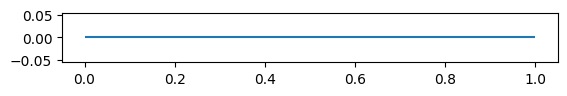

In [24]:
from shapely.affinity import rotate
from shapely.geometry import LineString, Point

start = Point(0, 0)
length = 1
angle = math.pi / 3

end = Point(start.x + length, start.y)
line = LineString([start, end])
#line = rotate(line, angle, origin=start, use_radians=True)
gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[line])
gdf.plot()

Find higher resolution maps
- https://stackoverflow.com/questions/73705036/python-geopandas-world-map-with-higher-resolution
- https://gis.stackexchange.com/questions/182944/seeking-polygon-shapefile-of-countries-states-and-islands

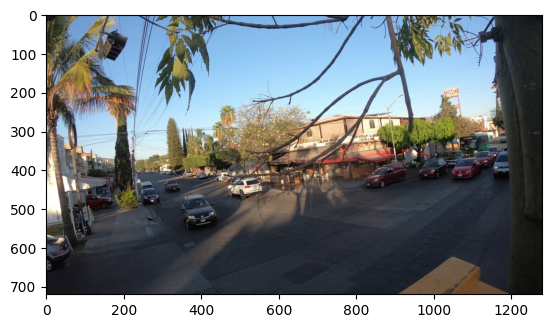

In [70]:
import matplotlib.pyplot as plt
img = cv2.cvtColor(video_analysis['frames'][selected_frame], cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [71]:
import folium
gdf.explore(column='c', cmap=['red', 'blue', 'green', 'yellow'], zoom_start=100, legend=True, k=2)

## Distance between two objects

In [72]:
ref = gdf['geometry'][0]
gdf["distance"] = gdf["geometry"].distance(ref)
gdf

/tmp/ipykernel_2113/2974551813.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["distance"] = gdf["geometry"].distance(ref)


,x,y,c,geometry,distance
0,-103.427910,20.636591,car,POINT (-103.42791 20.63659),0.000000
1,-103.427902,20.636688,car,POINT (-103.42790 20.63669),0.000098
2,-103.427917,20.636656,car,POINT (-103.42792 20.63666),0.000065
3,-103.427917,20.636391,car,POINT (-103.42792 20.63639),0.000200
4,-103.427902,20.636742,car,POINT (-103.42790 20.63674),0.000151
5,-103.427971,20.636770,car,POINT (-103.42797 20.63677),0.000189
6,-103.427917,20.636351,truck,POINT (-103.42792 20.63635),0.000240
7,-103.428009,20.636742,car,POINT (-103.42801 20.63674),0.000180
8,-103.427971,20.636349,car,POINT (-103.42797 20.63635),0.000250
9,-103.427803,20.636440,car,POINT (-103.42780 20.63644),0.000185


### EPSG:3310
- https://gis.stackexchange.com/questions/293310/finding-distance-between-two-points-with-geoseries-distance
- https://spatialreference.org/ref/epsg/3310/


In [73]:
gdf.to_crs(epsg=3310, inplace=True)
ref = gdf['geometry'][9]
gdf["distance"] = gdf["geometry"].distance(ref)
gdf

,x,y,c,geometry,distance
0,-103.427910,20.636591,car,POINT (1777297.179 -1751409.728),19.816913
1,-103.427902,20.636688,car,POINT (1777296.178 -1751399.331),28.613801
2,-103.427917,20.636656,car,POINT (1777295.162 -1751403.035),26.161653
3,-103.427917,20.636391,car,POINT (1777300.097 -1751430.982),13.429733
4,-103.427902,20.636742,car,POINT (1777295.184 -1751393.702),33.983570
5,-103.427971,20.636770,car,POINT (1777287.362 -1751391.973),39.684900
6,-103.427917,20.636351,truck,POINT (1777300.843 -1751435.204),15.628757
7,-103.428009,20.636742,car,POINT (1777283.846 -1751395.704),39.161723
8,-103.427971,20.636349,car,POINT (1777295.209 -1751436.406),20.576540
9,-103.427803,20.636440,car,POINT (1777311.322 -1751423.609),0.000000


### EPSG:32663
- Other option for georeference 
- https://spatialreference.org/ref/epsg/32663/

In [80]:
#gdf.to_crs(epsg=32662, inplace=True)
#ref = gdf['geometry'][9]
#gdf["distance"] = gdf["geometry"].distance(ref)
#gdf